In [ ]:
import pynapple as nap
from NWBMaker import NPNWBMaker
from spikeinterface import load_sorting_analyzer
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [ ]:
# define paths
nwb_paths = [
    Path("/data_store2/neuropixels/nwb/NP149_B1/NP149_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP150_B1/NP150_B1.nwb"),
]   

tumor_ids = [0, 1]

In [76]:
# first check the # good neurons for each recoding of interest
import fnmatch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy.linalg import norm
from scipy.stats import kstest
from scipy.stats import ttest_rel

# define variables to save out from loop
spike_indicies_final_list = []

# loop through all nwb files
for i in range(len(nwb_paths)):
    data = nap.load_file(nwb_paths[i])
    keys = data.keys()

    # find the spike TsGroup objects, number various based on recording apparatus
    template = "*imec*"
    keys = [key for key in keys if fnmatch.fnmatch(key, template)]
    # Preferentially select keys that do NOT have 'Th=' in them; if none, use all keys
    th_keys = [key for key in keys if "Th=" in key]
    if th_keys:
        # Preferentially select Th=8 if present
        th8_keys = [key for key in th_keys if "Th=8" in key]
        if th8_keys:
            keys = th8_keys
        else:
            keys = th_keys
    template = "*sentgen*" 
    keys = [key for key in keys if not fnmatch.fnmatch(key, template)]

    print(data)
    for s in range(len(keys)):
        spike_times = data[keys[s]]
        # print(spike_times)
        
        # 1. filter to good neurons
        firingRates_all = spike_times.metadata["rate"]
        task_times = data["TaskTimes"]
        beh_epochs = nap.IntervalSet(start=task_times.start, end=task_times.end)
        spike_times_beh = spike_times.restrict(beh_epochs)
        firingRates_beh = spike_times_beh.metadata["rate"]

        # calculate ks stats
        start_time = task_times.start
        end_time = task_times.end
        ks_stats = np.zeros(len(spike_times))
        ks_pvals = np.zeros(len(spike_times))
        for u in range(len(spike_times)):
            # get spike times for this unit
            test = spike_times[u].as_series().index.values

            # The null hypothesis is that the spike times are uniformly distributed between start_time and end_time
            if len(test) > 1:
                min_time = start_time[0]
                max_time = end_time[-1]
                # Normalize spike times to [0, 1] for KS test against uniform
                normalized_spike_times = (test - min_time) / (max_time - min_time)
                ks_result = kstest(normalized_spike_times, 'uniform')
                ks_stats[u] = ks_result.statistic
                ks_pvals[u] = ks_result.pvalue
            else:
                ks_stats[u] = np.nan
                ks_pvals[u] = np.nan

        # now do ISI calculation
        violationThreshold = 3/1000 #for 3 ms isi refractory period, what used before, middle of range that kilosort cites
        violationPct = np.zeros(len(spike_times))
        for u in range(len(spike_times)):
            unit = spike_times[u]
            unit = unit.as_series().index
            if len(unit) < 100:
                violationPct[u] = 1 
            else:
                isi = unit.diff()[1:len(unit)]
                violations = np.where(isi<violationThreshold)
                violations = np.array(violations)
                violationPct[u] = violations.size/len(isi)

        # now apply masks
        if "KSLabel" in spike_times.metadata:
            KSLabels = spike_times.metadata["KSLabel"]
        else:
            KSLabels = spike_times.metadata["quality"]
        firingRates = firingRates_beh
        mask1 = violationPct<3/100 # throwing out neurons with > 3% isi violations with isi = 3 ms; lose quite a bit with 5 ms esp when including cdf stats
        mask2 = firingRates>0.5 # firing rate > 0.5 ms during all behavior epochs
        mask3 = KSLabels!="noise" # not noise per auto label
        mask4 = ks_stats < 0.3 # KS stat < 0.3 (stability across recording)
        mask = mask1 & mask2 & mask3 & mask4
        indicesFinal = firingRates.index[mask]
        spike_times_good = spike_times_beh[indicesFinal]
        print(f"Subject: {i}, insertion: {s}, Initial Number: {len(spike_times)}, Number of good neurons: {len(spike_times_good)}")


        spike_indicies_final_list.append(indicesFinal)

NP149_B1
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                        │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ TaskTimes                   │ IntervalSet │
│ TaskStims                   │ IntervalSet │
│ TaskCues                    │ IntervalSet │
│ StimSpeechWords             │ IntervalSet │
│ StimSpeechTrials            │ IntervalSet │
│ StimSpeechPhones            │ IntervalSet │
│ ProdSpeechWords             │ IntervalSet │
│ ProdSpeechTrials            │ IntervalSet │
│ ProdSpeechPhones            │ IntervalSet │
│ KilosortSortTimes           │ IntervalSet │
│ pitch                       │ TsdFrame    │
│ intensity                   │ TsdFrame    │
│ artics_new                  │ TsdFrame    │
│ artics                      │ TsdFrame    │
│ NP149_B1_g0_imec0_KS4_Th=12 │ TsGroup     │
│ NP149_B1_g0_imec0_KS4       │ TsGroup     │
│ NP149_B1_g0_imec0           │ TsGroup     │
│ TimeSeriesNIDQ              │ TsdFrame    │
│ ElectricalSeriesLF     

/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Subject: 0, insertion: 0, Initial Number: 260, Number of good neurons: 32
NP150_B1
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                        │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ TaskTimes                   │ IntervalSet │
│ ProdSpeechWords             │ IntervalSet │
│ ProdSpeechTrials            │ IntervalSet │
│ ProdSpeechPhones            │ IntervalSet │
│ KilosortSortTimes           │ IntervalSet │
│ pitch                       │ TsdFrame    │
│ intensity                   │ TsdFrame    │
│ artics_new                  │ TsdFrame    │
│ artics                      │ TsdFrame    │
│ NP150_B1_g0_imec1_KS4_Th=12 │ TsGroup     │
│ NP150_B1_g0_imec1_KS4       │ TsGroup     │
│ NP150_B1_g0_imec1           │ TsGroup     │
│ NP150_B1_g0_imec0_KS4_Th=12 │ TsGroup     │
│ NP150_B1_g0_imec0_KS4       │ TsGroup     │
│ NP150_B1_g0_imec0           │ TsGroup     │
│ TimeSeriesNIDQ              │ TsdFrame    │
│ ElectricalSeriesLFImec1     │ TsdFrame   

/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Subject: 1, insertion: 0, Initial Number: 242, Number of good neurons: 15


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Subject: 1, insertion: 1, Initial Number: 197, Number of good neurons: 10


In [70]:
rec_id = 'NP150_B1'
nwb_path = f'/data_store2/neuropixels/nwb/{rec_id}/{rec_id}.nwb'
nwb_file = NPNWBMaker(file_path=nwb_path, rec_id=rec_id, make_log_file=False, silent=False)
nwb_file.initialize_nwbfile()
data = nap.load_file(nwb_path)
print(data)
spike_times = data['NP150_B1_g0_imec0_KS4_Th=12']
print(spike_times)
print(spike_indicies_final_list[2])

✅ Preprocessing root: /data_store2/neuropixels/preproc
✅ Raw data root: /data_store2/neuropixels/raw
✅ NWB file path: /data_store2/neuropixels/nwb/NP150_B1/NP150_B1.nwb
✅ Existing NWB file found — loading
✅ Loaded NWB instance from file
NP150_B1
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                        │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ TaskTimes                   │ IntervalSet │
│ ProdSpeechWords             │ IntervalSet │
│ ProdSpeechTrials            │ IntervalSet │
│ ProdSpeechPhones            │ IntervalSet │
│ KilosortSortTimes           │ IntervalSet │
│ pitch                       │ TsdFrame    │
│ intensity                   │ TsdFrame    │
│ artics_new                  │ TsdFrame    │
│ artics                      │ TsdFrame    │
│ NP150_B1_g0_imec1_KS4_Th=12 │ TsGroup     │
│ NP150_B1_g0_imec1_KS4       │ TsGroup     │
│ NP150_B1_g0_imec1           │ TsGroup     │
│ NP150_B1_g0_imec0_KS4_Th=12 │ TsGroup     │
│ NP150_B1_g0_imec

/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


In [ ]:
spike_times_good = spike_times[spike_indicies_final_list[2]]
rec_id = 'NP149_B1'
kilosort_run = 'NP149_B1_g0_imec0_KS4_Th=12'
analyzer_path = f'/data_store2/neuropixels/nwb/{rec_id}/SI/{kilosort_run}'
analyzer = load_sorting_analyzer(analyzer_path)
ext_templates = analyzer.get_extension("templates")
av_templates = ext_templates.get_data(operator="average")
median_templates = ext_templates.get_data(operator="median")
print(av_templates.shape)
print(median_templates.shape)

In [ ]:
# this prints out the average waveforms on the max channel for each good unit
for unit_index in analyzer.unit_ids[spike_indicies_final_list[2]]:
    fig, ax = plt.subplots()
    template = av_templates[unit_index]
    # Find the channel with the maximum absolute amplitude
    max_ch = np.argmax(np.max(np.abs(template), axis=0))
    template = template[:, max_ch]  # select only that channel
    ax.plot(template)
    ax.set_title(f"{unit_index}")

In [ ]:
# for each unit, get average waveform on only max channel
av_templates_max = np.zeros((len(analyzer.unit_ids), av_templates.shape[1]))
for unit_index in analyzer.unit_ids:
    template = av_templates[unit_index]
    # Find the channel with the maximum absolute amplitude
    max_ch = np.argmax(np.max(np.abs(template), axis=0))
    template = template[:, max_ch]
    av_templates_max[unit_index] = template
print(av_templates_max.shape)

# now cluster the waveforms
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Get waveforms for only the good units
good_unit_indices = spike_indicies_final_list[2]
good_waveforms = abs(av_templates_max[good_unit_indices])

# Standardize the waveforms for clustering
scaler = StandardScaler()
waveforms_scaled = scaler.fit_transform(good_waveforms)

# Try different numbers of clusters and evaluate with silhouette score
silhouette_scores = []
k_range = range(2, min(11, len(good_waveforms)//2))  # Don't exceed half the number of units

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(waveforms_scaled)
    silhouette_avg = silhouette_score(waveforms_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: silhouette score = {silhouette_avg:.3f}")

# Find optimal number of clusters
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

# Perform final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(waveforms_scaled)

# Identify and remove outlier clusters with very few units
min_cluster_size = max(3, len(good_waveforms) // 20)  # At least 3 units, or 5% of total units
print(f"Minimum cluster size threshold: {min_cluster_size}")

# Find clusters that are too small
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
small_clusters = unique_labels[counts < min_cluster_size]
print(f"Small clusters to remove: {small_clusters} (sizes: {counts[counts < min_cluster_size]})")

# Create mask for units in clusters that are large enough
keep_mask = np.isin(cluster_labels, unique_labels[counts >= min_cluster_size])
filtered_waveforms = good_waveforms[keep_mask]
filtered_unit_indices = good_unit_indices[keep_mask]
filtered_labels = cluster_labels[keep_mask]

print(f"Removed {len(good_waveforms) - len(filtered_waveforms)} outlier units")
print(f"Remaining units for clustering: {len(filtered_waveforms)}")

# Re-cluster the filtered data
if len(filtered_waveforms) > 10:  # Only re-cluster if we have enough data
    # Re-standardize the filtered waveforms
    scaler_filtered = StandardScaler()
    waveforms_scaled_filtered = scaler_filtered.fit_transform(filtered_waveforms)
    
    # Try different k values for filtered data
    k_range_filtered = range(2, min(11, len(filtered_waveforms)//2))
    silhouette_scores_filtered = []
    
    for k in k_range_filtered:
        kmeans_filtered = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels_filtered = kmeans_filtered.fit_predict(waveforms_scaled_filtered)
        silhouette_avg = silhouette_score(waveforms_scaled_filtered, cluster_labels_filtered)
        silhouette_scores_filtered.append(silhouette_avg)
        print(f"Filtered data k={k}: silhouette score = {silhouette_avg:.3f}")
    
    # Find optimal k for filtered data
    optimal_k_filtered = k_range_filtered[np.argmax(silhouette_scores_filtered)]
    print(f"\nOptimal number of clusters for filtered data: {optimal_k_filtered}")
    
    # Final clustering on filtered data
    final_kmeans_filtered = KMeans(n_clusters=optimal_k_filtered, random_state=42, n_init=10)
    final_cluster_labels = final_kmeans_filtered.fit_predict(waveforms_scaled_filtered)
    
    # Use filtered results
    use_filtered = True
    final_waveforms = filtered_waveforms
    final_unit_indices = filtered_unit_indices
    final_labels = final_cluster_labels
    optimal_k_final = optimal_k_filtered
    silhouette_scores_final = silhouette_scores_filtered
    k_range_final = k_range_filtered
else:
    print("Not enough data after filtering, using original clustering")
    use_filtered = False
    final_waveforms = good_waveforms
    final_unit_indices = good_unit_indices
    final_labels = cluster_labels
    optimal_k_final = optimal_k
    silhouette_scores_final = silhouette_scores
    k_range_final = k_range

# Plot silhouette scores
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores, 'bo-', label='Original data')
if use_filtered:
    plt.plot(k_range_final, silhouette_scores_final, 'ro-', label='Filtered data')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.grid(True)

# Plot clustered waveforms
plt.subplot(1, 3, 2)
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k_final))
for cluster_id in range(optimal_k_final):
    cluster_mask = final_labels == cluster_id
    cluster_waveforms = final_waveforms[cluster_mask]
    cluster_unit_ids = final_unit_indices[cluster_mask]
    
    # Plot individual waveforms in this cluster
    for i, waveform in enumerate(cluster_waveforms):
        alpha = 0.3 if len(cluster_waveforms) > 1 else 1.0
        plt.plot(waveform, color=colors[cluster_id], alpha=alpha, linewidth=0.8)
    
    # Plot cluster mean
    mean_waveform = np.mean(cluster_waveforms, axis=0)
    plt.plot(mean_waveform, color=colors[cluster_id], linewidth=3, 
             label=f'Cluster {cluster_id} (n={len(cluster_waveforms)})')

plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title(f'Clustered Waveforms (k={optimal_k_final})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot cluster size distribution
plt.subplot(1, 3, 3)
unique_labels_final, counts_final = np.unique(final_labels, return_counts=True)
plt.bar(range(len(counts_final)), counts_final, color=colors[:len(counts_final)])
plt.xlabel('Cluster ID')
plt.ylabel('Number of Units')
plt.title('Cluster Size Distribution')
plt.xticks(range(len(counts_final)), [f'C{i}' for i in unique_labels_final])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print cluster assignments
print(f"\nCluster assignments for {len(final_unit_indices)} units (after outlier removal):")
for cluster_id in range(optimal_k_final):
    cluster_mask = final_labels == cluster_id
    cluster_unit_ids = final_unit_indices[cluster_mask]
    print(f"Cluster {cluster_id}: Units {cluster_unit_ids.tolist()}")

# Print summary of removed outliers
if use_filtered:
    removed_count = len(good_unit_indices) - len(final_unit_indices)
    print(f"\nSummary:")
    print(f"- Good units: {len(good_unit_indices)}")
    print(f"- Outlier units removed: {removed_count}")
    print(f"- Units used for clustering: {len(final_unit_indices)}")
    print(f"- Optimal clusters: {optimal_k_final}")
else:
    print(f"\nNo outliers removed. Using all {len(good_unit_indices)} good units with {optimal_k_final} clusters.")

In [78]:
# now loop through all the runs and cluster them together to see if any cluster is overrepresented in the tumor group
tumor_ids = [0, 1, 1]
ks_rn_list = ['NP149_B1_g0_imec0_KS4_Th=12', 'NP150_B1_g0_imec1_KS4_Th=12', 'NP150_B1_g0_imec0_KS4_Th=12']
rec_id_list = ['NP149_B1', 'NP150_B1', 'NP150_B1']
av_template_max_good_list = []
tumor_id_list = []
run_id_list = []
for sess in range(len(spike_indicies_final_list)):
    # define paths and neurons for this run
    spike_indicies = spike_indicies_final_list[sess]
    kilosort_run = ks_rn_list[sess]
    rec_id = rec_id_list[sess]
    tumor_id = tumor_ids[sess]

    # load data
    analyzer_path = f'/data_store2/neuropixels/nwb/{rec_id}/SI/{kilosort_run}'
    analyzer = load_sorting_analyzer(analyzer_path)
    ext_templates = analyzer.get_extension("templates")
    av_templates = ext_templates.get_data(operator="average")
    median_templates = ext_templates.get_data(operator="median")

    # get max channel templates for the good units
    av_templates_max = np.zeros((len(analyzer.unit_ids[spike_indicies]), av_templates.shape[1]))
    runI = 0
    for unit_index in analyzer.unit_ids[spike_indicies]:
        template = av_templates[unit_index]
        # Find the channel with the maximum absolute amplitude
        max_ch = np.argmax(np.max(np.abs(template), axis=0))
        template = template[:, max_ch]
        av_templates_max[runI] = template
        runI += 1
    av_template_max_good_list.append(av_templates_max)
    tumor_id_list.extend([tumor_id] * len(spike_indicies))
    run_id_list.extend([sess] * len(spike_indicies))

Clustering 57 good units from all sessions
k=2: silhouette score = 0.440
k=3: silhouette score = 0.443
k=4: silhouette score = 0.168
k=5: silhouette score = 0.183
k=6: silhouette score = 0.182
k=7: silhouette score = 0.189
k=8: silhouette score = 0.173
k=9: silhouette score = 0.195
k=10: silhouette score = 0.220

Optimal number of clusters: 3


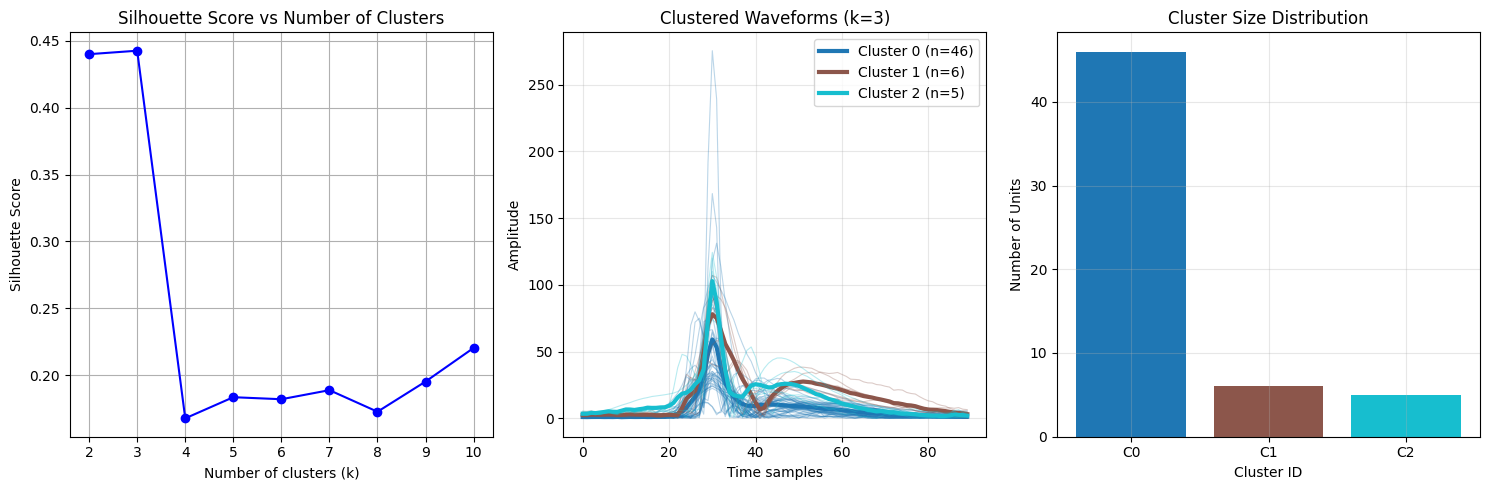

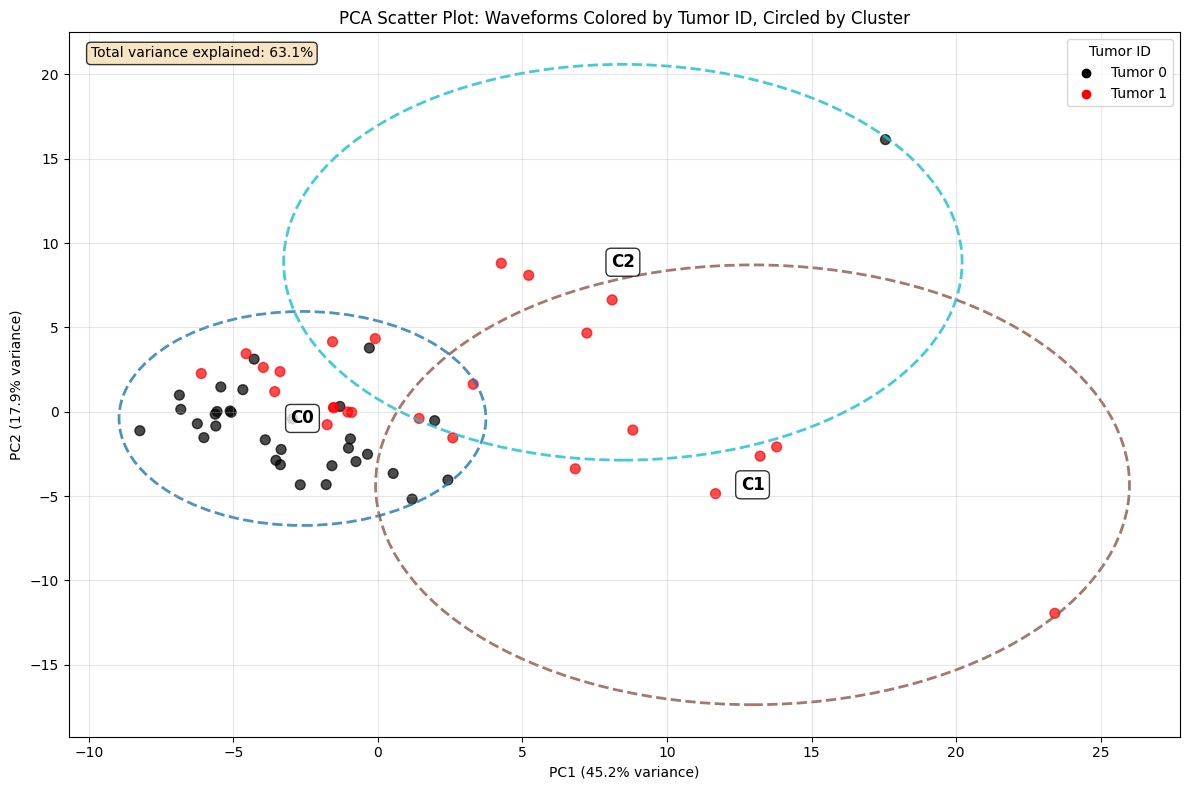

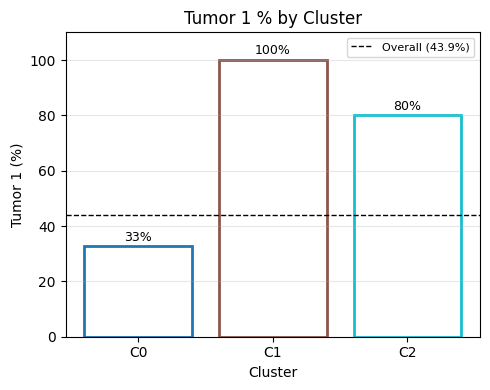


Cluster assignments for 57 units (after outlier removal):
Cluster 0 (n=46):
  Tumor distribution: {0: 31, 1: 15}
  Run IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Cluster 1 (n=6):
  Tumor distribution: {1: 6}
  Run IDs: [1, 1, 1, 1, 1, 2]
Cluster 2 (n=5):
  Tumor distribution: {0: 1, 1: 4}
  Run IDs: [0, 1, 1, 2, 2]

Summary:
- Total good units: 57
- Outlier units removed: 0
- Units used for clustering: 57
- Optimal clusters: 3

Detailed percentage breakdown by cluster:

Cluster 0 (n=46):
  Tumor ID breakdown:
    Tumor 0: 31/46 (67.4%)
    Tumor 1: 15/46 (32.6%)
  Session breakdown:
    Session 0: 31/46 (67.4%)
    Session 1: 8/46 (17.4%)
    Session 2: 7/46 (15.2%)

Cluster 1 (n=6):
  Tumor ID breakdown:
    Tumor 0: 0/6 (0.0%)
    Tumor 1: 6/6 (100.0%)
  Session breakdown:
    Session 0: 0/6 (0.0%)
    Session 1: 5/6 (83.3%)
    Session 2: 1/6 (16.7%)

Cluster 2 (n=5):
  Tumor ID bre

In [80]:
# concatenate all data together to feed to the k means clustering algorithm
av_template_max_good_matrix = np.concatenate(av_template_max_good_list, axis=0)
av_template_max_good_matrix = abs(av_template_max_good_matrix)

# Apply the same K-means clustering algorithm to av_template_max_good_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use the concatenated matrix of all good units from all sessions
all_good_waveforms = av_template_max_good_matrix
print(f"Clustering {all_good_waveforms.shape[0]} good units from all sessions")

# Standardize the waveforms for clustering
scaler = StandardScaler()
waveforms_scaled = scaler.fit_transform(all_good_waveforms)

# Try different numbers of clusters and evaluate with silhouette score
silhouette_scores = []
k_range = range(2, min(11, len(all_good_waveforms)//2))  # Don't exceed half the number of units

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(waveforms_scaled)
    silhouette_avg = silhouette_score(waveforms_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: silhouette score = {silhouette_avg:.3f}")

# Find optimal number of clusters
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

# Perform final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(waveforms_scaled)

# Use original results
final_waveforms = all_good_waveforms
final_tumor_ids = np.array(tumor_id_list)
final_run_ids = np.array(run_id_list)
optimal_k_final = optimal_k
silhouette_scores_final = silhouette_scores
k_range_final = k_range

# Plot silhouette scores
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

# Plot clustered waveforms
plt.subplot(1, 3, 2)
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k_final))
for cluster_id in range(optimal_k_final):
    cluster_mask = final_labels == cluster_id
    cluster_waveforms = final_waveforms[cluster_mask]
    
    # Plot individual waveforms in this cluster
    for i, waveform in enumerate(cluster_waveforms):
        alpha = 0.3 if len(cluster_waveforms) > 1 else 1.0
        plt.plot(waveform, color=colors[cluster_id], alpha=alpha, linewidth=0.8)
    
    # Plot cluster mean
    mean_waveform = np.mean(cluster_waveforms, axis=0)
    plt.plot(mean_waveform, color=colors[cluster_id], linewidth=3, 
             label=f'Cluster {cluster_id} (n={len(cluster_waveforms)})')

plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title(f'Clustered Waveforms (k={optimal_k_final})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot cluster size distribution
plt.subplot(1, 3, 3)
unique_labels_final, counts_final = np.unique(final_labels, return_counts=True)
plt.bar(range(len(counts_final)), counts_final, color=colors[:len(counts_final)])
plt.xlabel('Cluster ID')
plt.ylabel('Number of Units')
plt.title('Cluster Size Distribution')
plt.xticks(range(len(counts_final)), [f'C{i}' for i in unique_labels_final])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create PCA scatter plot colored by tumor ID and circled by cluster
from sklearn.decomposition import PCA

# Perform PCA on the standardized waveforms
pca = PCA(n_components=2)
waveforms_pca = pca.fit_transform(waveforms_scaled)

# Create the scatter plot
plt.figure(figsize=(12, 8))

# Define colors for tumor IDs
tumor_colors = {0: 'black', 1: 'red'}
colors_for_plot = [tumor_colors[tumor_id] for tumor_id in final_tumor_ids]

# Plot each point colored by tumor ID
scatter = plt.scatter(waveforms_pca[:, 0], waveforms_pca[:, 1], 
                     c=colors_for_plot, alpha=0.7, s=50)

# Add cluster circles
for cluster_id in range(optimal_k_final):
    cluster_mask = final_labels == cluster_id
    cluster_points = waveforms_pca[cluster_mask]
    
    if len(cluster_points) > 0:
        # Calculate cluster center
        center = np.mean(cluster_points, axis=0)
        
        # Calculate radius as max distance from center
        distances = np.linalg.norm(cluster_points - center, axis=1)
        radius = np.max(distances) + 0.1  # Add small buffer
        
        # Draw circle using the same colors as the first plot
        colors = plt.cm.tab10(np.linspace(0, 1, optimal_k_final))
        circle = plt.Circle(center, radius, fill=False, 
                          color=colors[cluster_id], 
                          linewidth=2, linestyle='--', alpha=0.8)
        plt.gca().add_patch(circle)
        
        # Add cluster label
        plt.text(center[0], center[1], f'C{cluster_id}', 
                ha='center', va='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA Scatter Plot: Waveforms Colored by Tumor ID, Circled by Cluster')
plt.grid(True, alpha=0.3)

# Add legend for tumor colors
legend_elements = [plt.scatter([], [], c='black', label='Tumor 0'),
                  plt.scatter([], [], c='red', label='Tumor 1')]
plt.legend(handles=legend_elements, title='Tumor ID', loc='upper right')

# Add text box with PCA variance information
textstr = f'Total variance explained: {sum(pca.explained_variance_ratio_[:2]):.1%}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Create small bar plot showing tumor percentage per cluster
plt.figure(figsize=(5, 4))

# Calculate tumor percentages for each cluster
cluster_tumor_percentages = []
cluster_sizes = []
cluster_labels_list = []

for cluster_id in range(optimal_k_final):
    cluster_mask = final_labels == cluster_id
    cluster_tumor_ids = final_tumor_ids[cluster_mask]
    cluster_size = len(cluster_tumor_ids)
    
    # Calculate percentage of tumor 1 (red) in this cluster
    tumor_1_count = np.sum(cluster_tumor_ids == 1)
    tumor_1_percentage = (tumor_1_count / cluster_size) * 100 if cluster_size > 0 else 0
    
    cluster_tumor_percentages.append(tumor_1_percentage)
    cluster_sizes.append(cluster_size)
    cluster_labels_list.append(f'C{cluster_id}')

# Calculate overall tumor 1 percentage in the dataset
overall_tumor_1_percentage = (np.sum(final_tumor_ids == 1) / len(final_tumor_ids)) * 100

# Create the bar plot with colors matching the first plot
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k_final))
bars = plt.bar(range(len(cluster_tumor_percentages)), cluster_tumor_percentages, 
               color='white', edgecolor=colors, linewidth=2)

# Add dashed line for overall tumor percentage
plt.axhline(y=overall_tumor_1_percentage, color='black', linestyle='--', linewidth=1, 
           label=f'Overall ({overall_tumor_1_percentage:.1f}%)')

# Customize the plot
plt.xlabel('Cluster')
plt.ylabel('Tumor 1 (%)')
plt.title('Tumor 1 % by Cluster')
plt.xticks(range(len(cluster_labels_list)), cluster_labels_list)

# Add value labels on top of bars
for i, (bar, percentage) in enumerate(zip(bars, cluster_tumor_percentages)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{percentage:.0f}%', ha='center', va='bottom', fontsize=9)

# Add legend
plt.legend(loc='upper right', fontsize=8)

# Add grid
plt.grid(True, alpha=0.3, axis='y')

# Set y-axis limits to show the full range
plt.ylim(0, max(max(cluster_tumor_percentages), overall_tumor_1_percentage) + 10)

plt.tight_layout()
plt.show()

# Print cluster assignments with tumor and run information
print(f"\nCluster assignments for {len(final_waveforms)} units (after outlier removal):")
for cluster_id in range(optimal_k_final):
    cluster_mask = final_labels == cluster_id
    cluster_tumor_ids = final_tumor_ids[cluster_mask]
    cluster_run_ids = final_run_ids[cluster_mask]
    
    # Count units by tumor ID
    tumor_counts = {}
    for tumor_id in cluster_tumor_ids:
        tumor_counts[tumor_id] = tumor_counts.get(tumor_id, 0) + 1
    
    print(f"Cluster {cluster_id} (n={len(cluster_tumor_ids)}):")
    print(f"  Tumor distribution: {tumor_counts}")
    print(f"  Run IDs: {cluster_run_ids.tolist()}")

# Print summary of removed outliers
if use_filtered:
    removed_count = len(all_good_waveforms) - len(final_waveforms)
    print(f"\nSummary:")
    print(f"- Total good units: {len(all_good_waveforms)}")
    print(f"- Outlier units removed: {removed_count}")
    print(f"- Units used for clustering: {len(final_waveforms)}")
    print(f"- Optimal clusters: {optimal_k_final}")
else:
    print(f"\nNo outliers removed. Using all {len(all_good_waveforms)} good units with {optimal_k_final} clusters.")

# Calculate percentages for each cluster
print(f"\nDetailed percentage breakdown by cluster:")
print("=" * 60)

for cluster_id in range(optimal_k_final):
    cluster_mask = final_labels == cluster_id
    cluster_tumor_ids = final_tumor_ids[cluster_mask]
    cluster_run_ids = final_run_ids[cluster_mask]
    cluster_size = len(cluster_tumor_ids)
    
    print(f"\nCluster {cluster_id} (n={cluster_size}):")
    
    # Calculate tumor percentages
    tumor_0_count = np.sum(cluster_tumor_ids == 0)
    tumor_1_count = np.sum(cluster_tumor_ids == 1)
    
    tumor_0_pct = (tumor_0_count / cluster_size) * 100 if cluster_size > 0 else 0
    tumor_1_pct = (tumor_1_count / cluster_size) * 100 if cluster_size > 0 else 0
    
    print(f"  Tumor ID breakdown:")
    print(f"    Tumor 0: {tumor_0_count}/{cluster_size} ({tumor_0_pct:.1f}%)")
    print(f"    Tumor 1: {tumor_1_count}/{cluster_size} ({tumor_1_pct:.1f}%)")
    
    # Calculate session percentages
    sess_0_count = np.sum(cluster_run_ids == 0)
    sess_1_count = np.sum(cluster_run_ids == 1)
    sess_2_count = np.sum(cluster_run_ids == 2)
    
    sess_0_pct = (sess_0_count / cluster_size) * 100 if cluster_size > 0 else 0
    sess_1_pct = (sess_1_count / cluster_size) * 100 if cluster_size > 0 else 0
    sess_2_pct = (sess_2_count / cluster_size) * 100 if cluster_size > 0 else 0
    
    print(f"  Session breakdown:")
    print(f"    Session 0: {sess_0_count}/{cluster_size} ({sess_0_pct:.1f}%)")
    print(f"    Session 1: {sess_1_count}/{cluster_size} ({sess_1_pct:.1f}%)")
    print(f"    Session 2: {sess_2_count}/{cluster_size} ({sess_2_pct:.1f}%)")

# Overall summary statistics
print(f"\nOverall summary:")
print("=" * 60)
total_units = len(final_waveforms)
total_tumor_0 = np.sum(final_tumor_ids == 0)
total_tumor_1 = np.sum(final_tumor_ids == 1)
total_sess_0 = np.sum(final_run_ids == 0)
total_sess_1 = np.sum(final_run_ids == 1)
total_sess_2 = np.sum(final_run_ids == 2)

print(f"Total units: {total_units}")
print(f"Tumor distribution: 0={total_tumor_0} ({total_tumor_0/total_units*100:.1f}%), 1={total_tumor_1} ({total_tumor_1/total_units*100:.1f}%)")
print(f"Session distribution: 0={total_sess_0} ({total_sess_0/total_units*100:.1f}%), 1={total_sess_1} ({total_sess_1/total_units*100:.1f}%), 2={total_sess_2} ({total_sess_2/total_units*100:.1f}%)")
